ltv; vol; spotPrice; loanAmount; fee; reclaimable; callValue; intrinsicVal; timeVal; callDelta
10.00%; 50.00%; 30.00; 3.00; 0.11%; 1.00; 27.03; 27.00; 0.03; 1.00
10.00%; 100.00%; 30.00; 3.00; 0.11%; 1.00; 27.03; 27.00; 0.03; 1.00
10.00%; 150.00%; 30.00; 3.00; 0.28%; 1.00; 27.08; 27.00; 0.08; 1.00
10.00%; 200.00%; 30.00; 3.00; 0.98%; 0.99; 27.27; 27.00; 0.27; 0.99
25.00%; 50.00%; 30.00; 7.50; 0.33%; 1.00; 22.57; 22.50; 0.07; 1.00
25.00%; 100.00%; 30.00; 7.50; 0.73%; 0.99; 22.67; 22.50; 0.17; 0.99
25.00%; 150.00%; 30.00; 7.50; 3.04%; 0.97; 23.21; 22.50; 0.71; 0.97
25.00%; 200.00%; 30.00; 7.50; 6.70%; 0.93; 24.12; 22.50; 1.62; 0.95
50.00%; 50.00%; 30.00; 15.00; 1.40%; 0.99; 15.21; 15.00; 0.21; 0.98
50.00%; 100.00%; 30.00; 15.00; 8.30%; 0.92; 16.36; 15.00; 1.36; 0.91
50.00%; 150.00%; 30.00; 15.00; 18.03%; 0.82; 18.30; 15.00; 3.30; 0.88
50.00%; 200.00%; 30.00; 15.00; 26.41%; 0.74; 20.38; 15.00; 5.38; 0.89
75.00%; 50.00%; 30.00; 22.50; 14.13%; 0.86; 8.73; 7.50; 1.23; 0.85
75.00%; 100.00%; 30

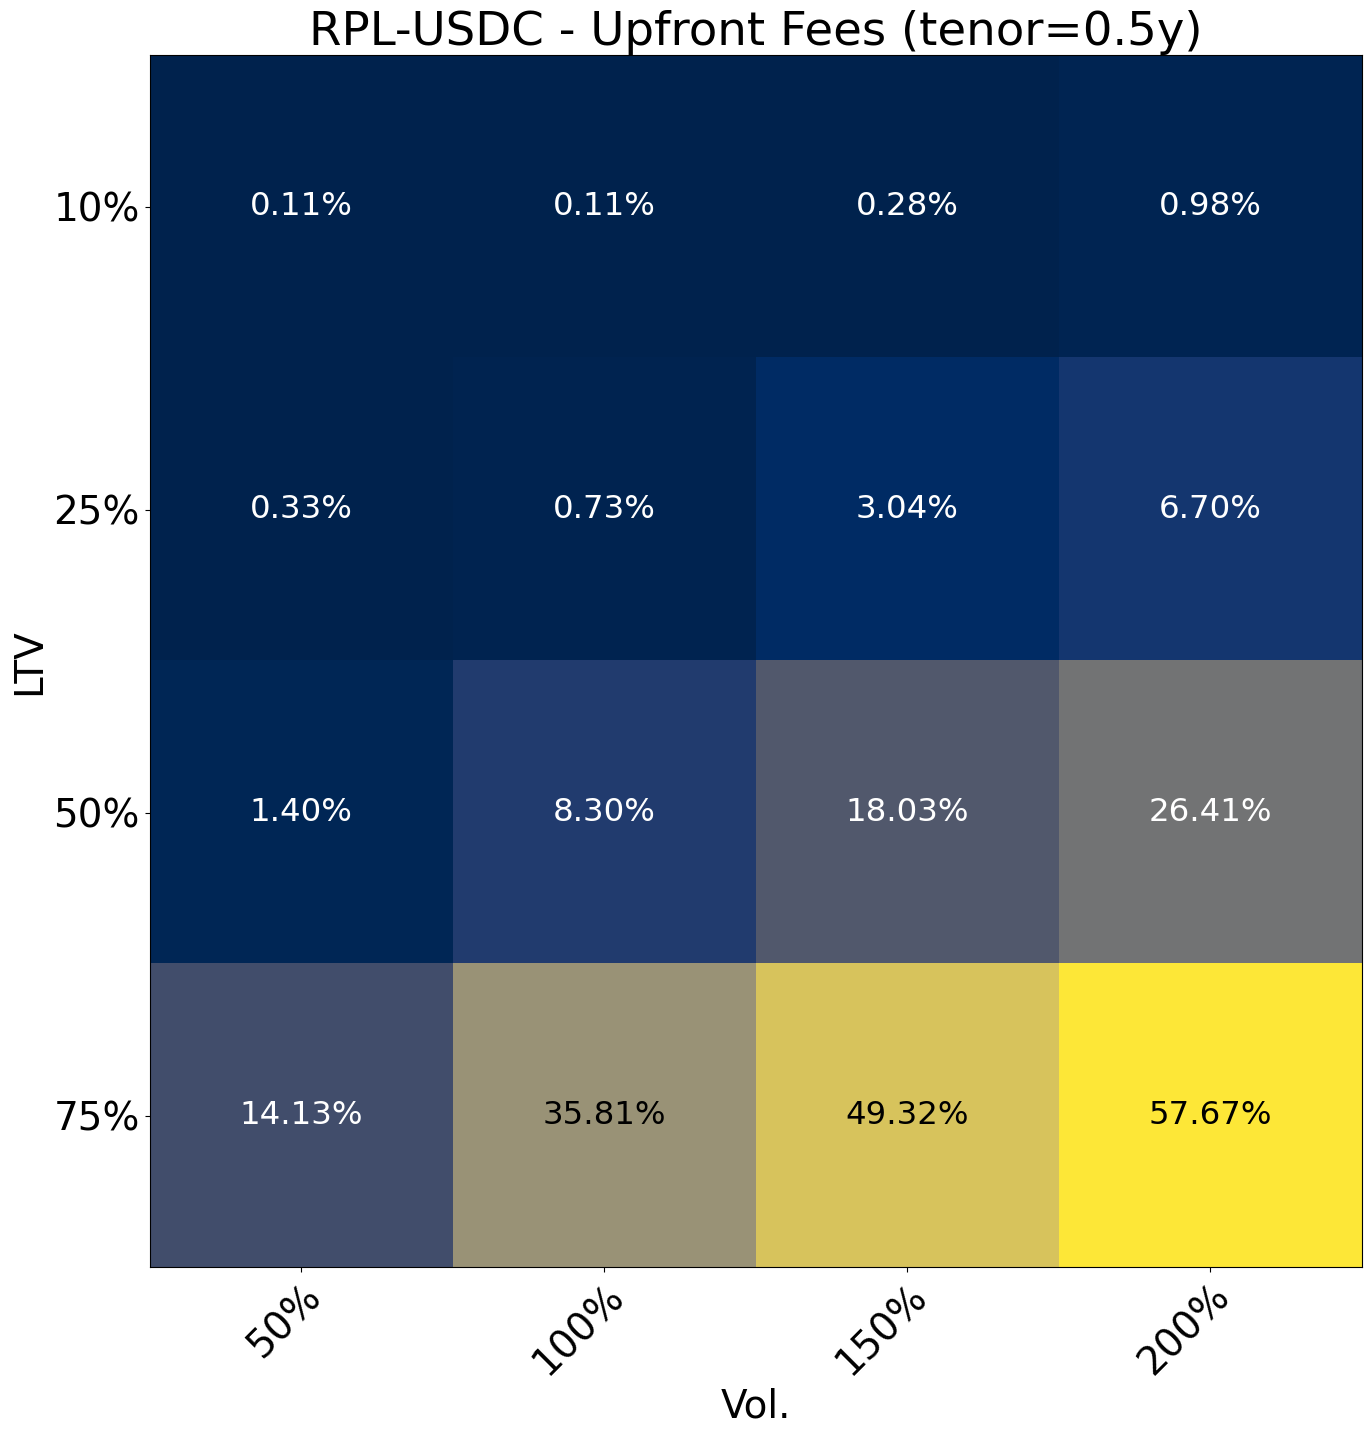

ltv; vol; spotPrice; loanAmount; apr; strike; callValue; intrinsicVal; timeVal; callDelta
10.00%; 50.00%; 30.00; 3.00; 2.01%; 3.03; 27.00; 26.97; 0.03; 1.00
10.00%; 100.00%; 30.00; 3.00; 2.07%; 3.03; 27.00; 26.97; 0.03; 1.00
10.00%; 150.00%; 30.00; 3.00; 5.40%; 3.08; 27.00; 26.92; 0.08; 1.00
10.00%; 200.00%; 30.00; 3.00; 22.12%; 3.33; 27.00; 26.67; 0.33; 0.99
25.00%; 50.00%; 30.00; 7.50; 2.01%; 7.58; 22.50; 22.42; 0.08; 1.00
25.00%; 100.00%; 30.00; 7.50; 4.73%; 7.68; 22.50; 22.32; 0.18; 0.99
25.00%; 150.00%; 30.00; 7.50; 24.79%; 8.43; 22.50; 21.57; 0.93; 0.96
25.00%; 200.00%; 30.00; 7.50; 77.30%; 10.40; 22.50; 19.60; 2.90; 0.93
50.00%; 50.00%; 30.00; 15.00; 2.99%; 15.22; 15.00; 14.78; 0.22; 0.98
50.00%; 100.00%; 30.00; 15.00; 25.75%; 16.93; 15.00; 13.07; 1.93; 0.88
50.00%; 150.00%; 30.00; 15.00; 93.27%; 22.00; 15.00; 8.00; 7.00; 0.80
50.00%; 200.00%; 30.00; 15.00; 239.97%; 33.00; 15.00; 0.00; 15.00; 0.74
75.00%; 50.00%; 30.00; 22.50; 15.58%; 24.25; 7.50; 5.75; 1.75; 0.79
75.00%; 100.00

<Figure size 640x480 with 0 Axes>

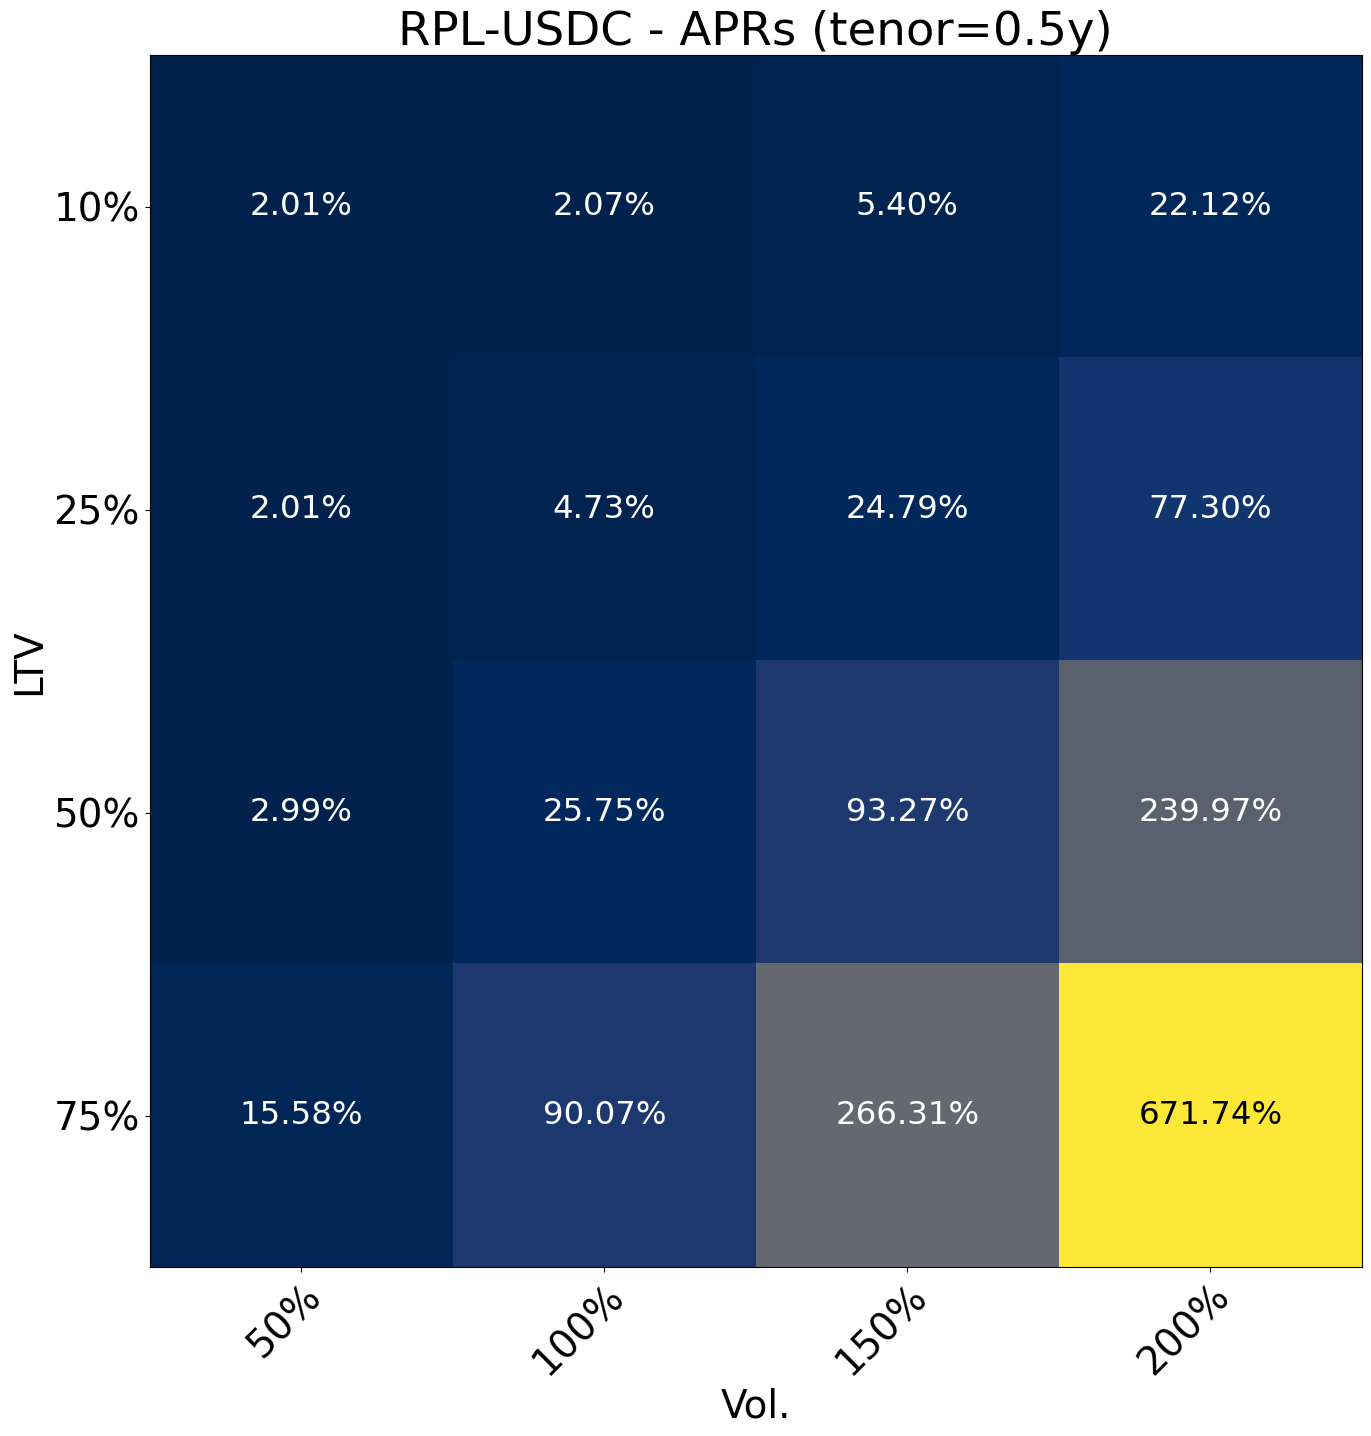

<Figure size 640x480 with 0 Axes>

In [8]:
import numpy as np
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt

CMAP = "cividis"

def getD1(S, K, vol, dt, r):
    return (np.log(S / K) + (r + vol**2 / 2) * dt) / \
        (vol * np.sqrt(dt))

def getCallPrice(spotPrice, strikePrice, vol, dt,riskFreeRate):
    if dt <= 0:
        return max([0, spotPrice - strikePrice])
    if strikePrice <= 0:
        return spotPrice
    d1 = getD1(spotPrice, strikePrice, vol, dt, riskFreeRate)
    d2 = d1 - vol * np.sqrt(dt)
    value = spotPrice * norm.cdf(d1) - strikePrice * \
        np.exp(-riskFreeRate * dt) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return value, delta

def getEquilibriumFee(loanAmount, spotPrice, vol, riskFreeRate, loanTenorInYears):
    def getSwapValue(fee):
        callPrice, _ = getCallPrice(spotPrice, loanAmount, vol, loanTenorInYears, riskFreeRate)
        swapValue = -1*spotPrice + loanAmount + callPrice*(1-fee)
        return swapValue
    
    def minFunc(fee):
        swapValue = getSwapValue(fee)
        return swapValue**2

    initFeeGuess = .5
    feeBnds = (.0, 1.)
    res = optimize.minimize(
        minFunc,
        args=(),
        x0=[initFeeGuess],
        bounds=[feeBnds])
        
    callPrice, callDelta = getCallPrice(spotPrice, loanAmount, vol, loanTenorInYears, riskFreeRate)
    intrinsicVal = max([spotPrice - loanAmount, 0])
    timeVal = callPrice - intrinsicVal

    if res["success"] and res["fun"] < 0.1:
        fee = res['x'][0]
    else:
        fee = None
        
    return fee, callPrice, intrinsicVal, timeVal, callDelta

def getEquilibriumApr(loanAmount, spotPrice, vol, riskFreeRate, loanTenorInYears):
    def getSwapValue(strike):
        callPrice, _ = getCallPrice(spotPrice, strike, vol, loanTenorInYears, riskFreeRate)
        swapValue = -1*spotPrice + loanAmount + callPrice
        return swapValue
    
    def minFunc(strike):
        swapValue = getSwapValue(strike)
        return swapValue**2

    initStrikeGuess = spotPrice
    strikeBnds = (.0000001, None)
    res = optimize.minimize(
        minFunc,
        args=(),
        x0=[initStrikeGuess],
        bounds=[strikeBnds])
        
    strike = res['x'][0]
    callPrice, callDelta = getCallPrice(spotPrice, strike, vol, loanTenorInYears, riskFreeRate)
    intrinsicVal = max([spotPrice - strike, 0])
    timeVal = callPrice - intrinsicVal
    
    if res["success"] and res["fun"] < 0.1:
        strike = res['x'][0]
        apr = (strike/loanAmount-1)/loanTenorInYears
    else:
        strike = None
        apr = None
        
    return strike, apr, callPrice, intrinsicVal, timeVal, callDelta

def upfrontFeeHeatmap(params):
    print("ltv; vol; spotPrice; loanAmount; fee; reclaimable; callValue; intrinsicVal; timeVal; callDelta")
    feeRes = []
    for ltv in params["ltvRange"]:
        tmp = []
        params["loanAmount"] = params["spotPrice"]*ltv
        for vol in params["volRange"]:
            args = dict((k, params[k]) for k in ("loanAmount", "spotPrice", "riskFreeRate", "loanTenorInYears"))
            args["vol"] = vol
            (fee, callPrice, intrinsicVal, timeVal, callDelta) = getEquilibriumFee(**args)
            tmp.append(fee)
            print("{:.2f}%; {:.2f}%; {:.2f}; {:.2f}; {:.2f}%; {:.2f}; {:.2f}; {:.2f}; {:.2f}; {:.2f}".format(ltv*100, vol*100, params["spotPrice"], params["loanAmount"], fee*100, 1-fee, callPrice, intrinsicVal, timeVal, callDelta))
        feeRes.append(tmp)
    print(feeRes)
    
    plt.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(15, 15))
    cmap = plt.cm.get_cmap(CMAP)
    ax.imshow(feeRes, cmap=CMAP)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(params["volRange"])), labels=["{:.0f}%".format(x*100) for x in params["volRange"]])
    ax.set_yticks(np.arange(len(params["ltvRange"])), labels=["{:.0f}%".format(x*100) for x in params["ltvRange"]])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    normColors = plt.cm.colors.Normalize(vmin=np.min(feeRes), vmax=np.max(feeRes))
    for i in range(len(params["ltvRange"])):
        for j in range(len(params["volRange"])):
            bg = cmap(normColors(feeRes[i][j]))
            v = 0 if (bg[0] + bg[1] + bg[2]) / 3 > 0.5 else 1
            c = (v, v, v, 1.)
            ax.text(j, i, "{:.2f}%".format(feeRes[i][j]*100),
                    ha="center", va="center", color=c, fontsize="smaller")
    
    ax.set_title("{} - Upfront Fees (tenor={:.1f}y)".format(params["pair"], params["loanTenorInYears"]))
    ax.set_ylabel("LTV")
    ax.set_xlabel("Vol.")
    fig.tight_layout()
    plt.show()
    fig.savefig('{} aprs.png'.format(params["pair"]), dpi=fig.dpi)
    plt.clf()
    
def aprHeatmap(params):
    print("ltv; vol; spotPrice; loanAmount; apr; strike; callValue; intrinsicVal; timeVal; callDelta")
    aprRes = []
    for ltv in params["ltvRange"]:
        tmp = []
        params["loanAmount"] = params["spotPrice"]*ltv
        for vol in params["volRange"]:
            args = dict((k, params[k]) for k in ("loanAmount", "spotPrice", "riskFreeRate", "loanTenorInYears"))
            args["vol"] = vol
            (strike, apr, callPrice, intrinsicVal, timeVal, callDelta) = getEquilibriumApr(**args)
            tmp.append(apr)
            print("{:.2f}%; {:.2f}%; {:.2f}; {:.2f}; {:.2f}%; {:.2f}; {:.2f}; {:.2f}; {:.2f}; {:.2f}".format(ltv*100, vol*100, params["spotPrice"], params["loanAmount"], apr*100, strike, callPrice, intrinsicVal, timeVal, callDelta))
        aprRes.append(tmp)
    print(aprRes)
    
    plt.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(15, 15))
    cmap = plt.cm.get_cmap(CMAP)
    ax.imshow(aprRes, cmap=CMAP)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(params["volRange"])), labels=["{:.0f}%".format(x*100) for x in params["volRange"]])
    ax.set_yticks(np.arange(len(params["ltvRange"])), labels=["{:.0f}%".format(x*100) for x in params["ltvRange"]])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    normColors = plt.cm.colors.Normalize(vmin=np.min(aprRes), vmax=np.max(aprRes))
    for i in range(len(params["ltvRange"])):
        for j in range(len(params["volRange"])):
            bg = cmap(normColors(aprRes[i][j]))
            v = 0 if (bg[0] + bg[1] + bg[2]) / 3 > 0.5 else 1
            c = (v, v, v, 1.)
            ax.text(j, i, "{:.2f}%".format(aprRes[i][j]*100),
                    ha="center", va="center", color=c, fontsize="smaller")
    
    ax.set_title("{} - APRs (tenor={:.1f}y)".format(params["pair"], params["loanTenorInYears"]))
    ax.set_ylabel("LTV")
    ax.set_xlabel("Vol.")
    fig.tight_layout()
    plt.show()
    fig.savefig('{} - aprs.png'.format(params["pair"]), dpi=fig.dpi)
    plt.clf()
    
if __name__ == "__main__":
    params = {
        "pair": "RPL-USDC",
        "ltvRange": [.1, .25, .5, .75],
        "volRange": [.5, 1., 1.5, 2.],
        "spotPrice": 30.,
        "riskFreeRate": .02,
        "loanTenorInYears": 1./2
    }
    upfrontFeeHeatmap(params)
    aprHeatmap(params)
